In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from math import exp

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, Margin, IMC_Tuning
import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

from importlib import reload
package_LAB = reload(package_LAB)

## Scenario

In [8]:
Scenario = "TCLAB_Simu"

if(Scenario == "TestMan"):
    TSim = 3000

    SPPath = {0:60, 1500:50, TSim:50}
    MVManPath = {0:60, TSim:0}
    ManPath = {0:1, 1500:0, TSim:0}
    DVPath = {0:10, 700:30, 1500:20, TSim:10}
    ManFF = False

if(Scenario == "TCLAB_Simu"):
    TSim = 2500

    SPPath = {0:75, 1300:65, 1500:65, TSim:65}
    MVManPath = {0:50, TSim:50}
    ManPath = {0:1, 500:0, TSim:0}
    DVPath = {0:50, 2000:60, TSim:60}
    ManFF = False

## Calcul de DV0 & PV0

In [9]:
nameFile1 = 'Open_loop_experiment_on_MV_2024-03-18-09h26.txt'

titleName1 = nameFile1.split('.')[0]
data1 = pd.read_csv(nameFile1)
t1 = data1['t'].values - data1['t'].values[0]

PV0 = 0
for i in range(len(t1)):
    PV0 += data1['PV'].values[i]
PV0 = PV0/len(t1)
print(PV0)

nameFile2 = 'Open_loop_experiment_on_DV_2024-03-18-19h49.txt'

titleName2 = nameFile2.split('.')[0]
data2= pd.read_csv(nameFile2)
t2 = data2['t'].values - data2['t'].values[0]

DV0 = 0
for i in range(len(t2)):
    DV0 += data2['PV'].values[i]
DV0 = DV0/len(t2)
print(DV0)

70.1002900552487
71.16462850182711


## Simulation Closed loop Parameters

In [10]:
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 70

t = []
MV = [MV0]
E = []
SP = []
PV = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []
DV = []
Man = []
MVMan = []
MVFF = []
MVFF_Delay = []
MV_Delayp = []
MV_Delayd = []
MVP = []
MVI = []
MVD = []


# Parameters
Kp = 1
Kd = 1
KpExp = 0.4971
KdExp = 0.3734
Kff = KdExp/KpExp #0.7512

alpha = 0.9
theta_pExp = 4.386
theta_dExp = 12.181
theta_ffExp = max(0, theta_dExp-theta_pExp)

theta_p = 2
theta_d = 2

MVMin = 0
MVMax = 100

T1d = 153.9969
T2d = 42.4662

T1p = 201.8353
T2p = 14.1389

MVFFdv = []
MVFFpv = []

T1 = T1p
T2 = T2p
gamma = 0.4

## Simulation Closed loop


(0.0, 2500.0)

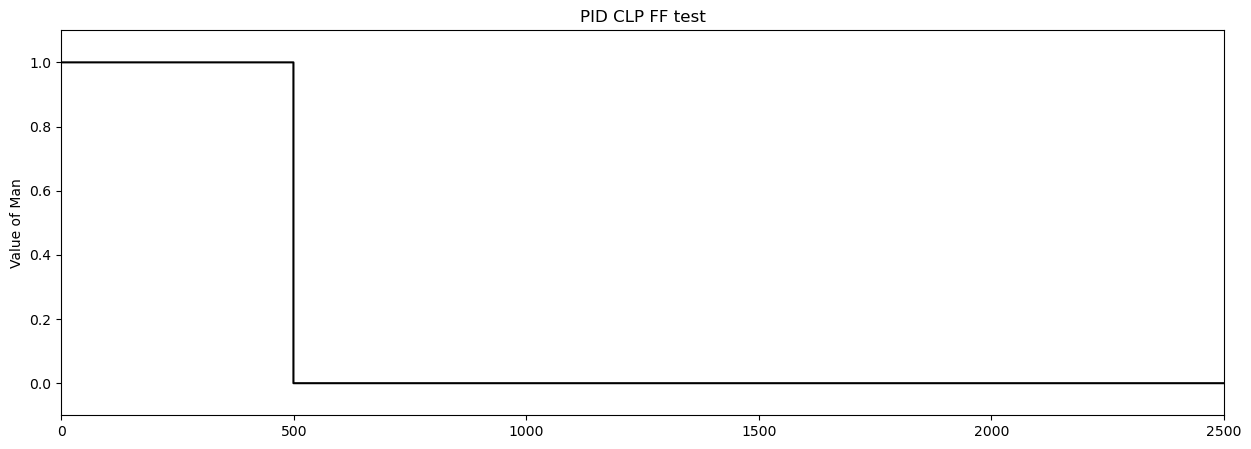

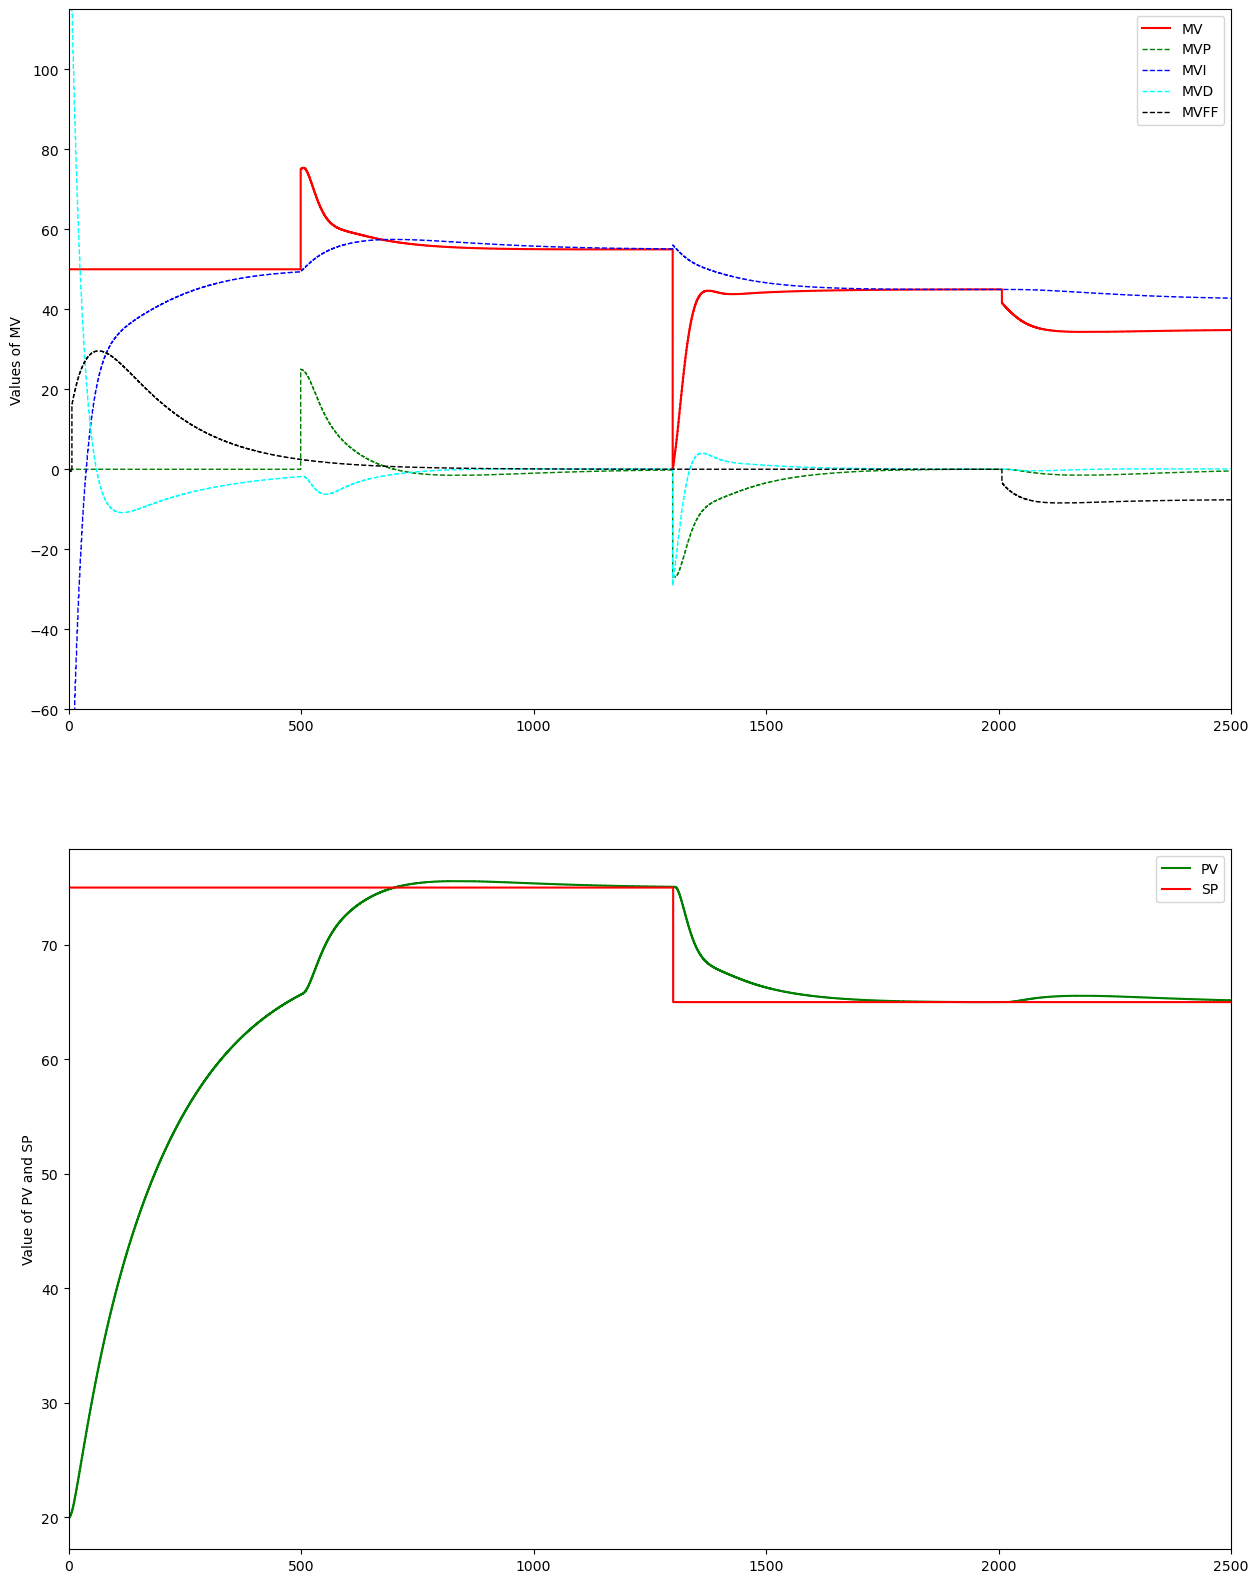

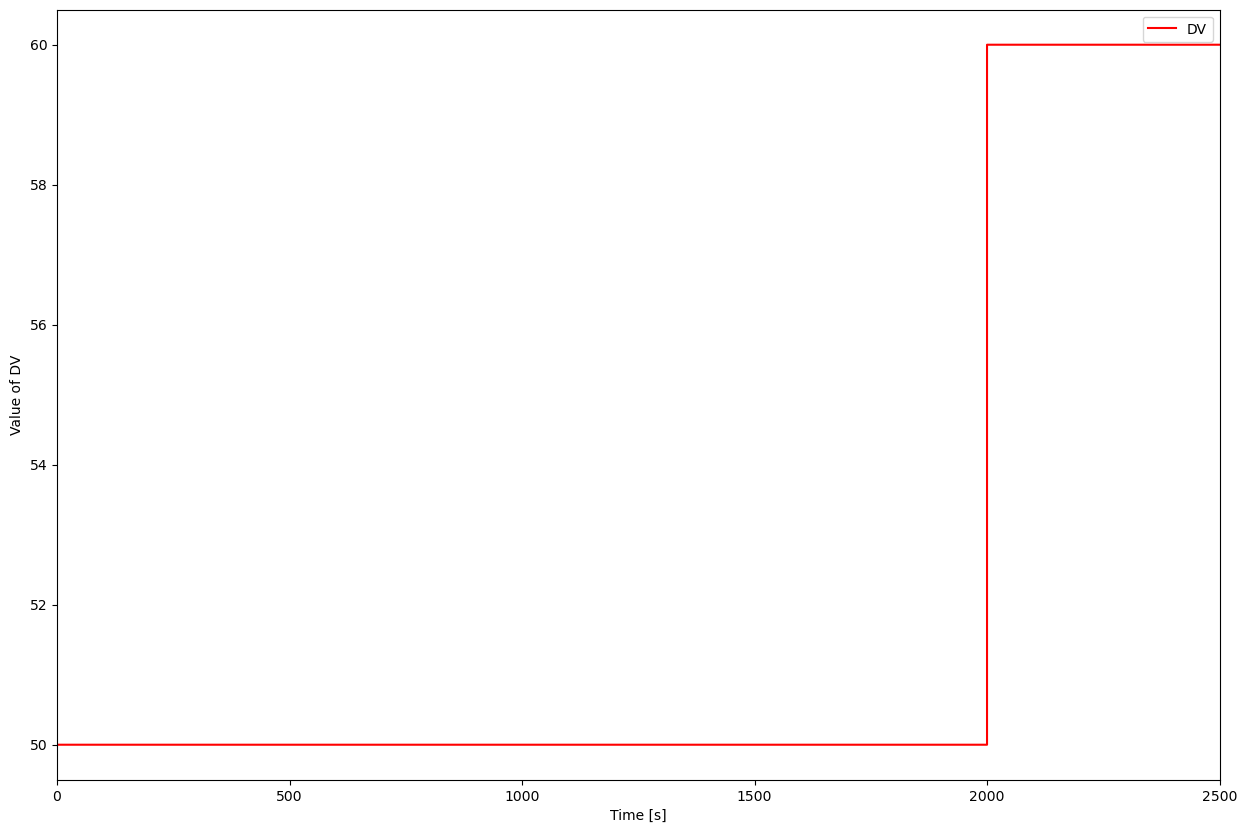

In [11]:
[Kc, Ti, Td] = IMC_Tuning(T1, T2, T1p, gamma, Kp)


for i in range(0,N-1):
    t.append(i*Ts)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(MVManPath,t,MVMan)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(DVPath,t,DV)
    
    
    #MVFF
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([theta_dExp-theta_pExp,0]),Ts,MVFF_Delay, DV0)
    
    LeadLag_RT(MVFF_Delay, -Kff, T1p, T1d, Ts, MVFFdv)
    LeadLag_RT(MVFFdv, 1, T2p, T2d, Ts, MVFF)

    
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)
    
    
    
    Delay_RT(MV, theta_pExp, Ts, MV_Delayp, MV0)
    
    FO_RT(MV_Delayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    Delay_RT(DV - DV0*np.ones_like(DV),theta_dExp,Ts,MV_Delayd, DV0)
    
    FO_RT(MV_Delayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)
    

plt.figure(figsize = (15,5))

plt.subplot(1,1,1)
plt.step(t,Man,'black',label='Man',where='pre')
plt.ylabel('Value of Man')
plt.title('PID CLP FF test')
plt.xlim([0, TSim])
plt.ylim([-0.1,1.1])

plt.figure(figsize = (15,20))

plt.subplot(2,1,1)
plt.step(t,MV,'r-',label='MV',where='pre')
plt.step(t,MVP,'green',label='MVP',where='pre', ls = '--', linewidth = '1' )
plt.step(t,MVI,'blue',label='MVI',where='pre', ls = '--', linewidth = '1')
plt.step(t,MVD,'cyan',label='MVD',where='pre', ls = '--', linewidth = '1')
plt.step(t,MVFF,'black',label='MVFF',where='pre', ls = '--', linewidth = '1')
plt.ylabel('Values of MV')
plt.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.xlim([0, TSim])
plt.ylim([-60,115])

plt.subplot(2,1,2)
plt.step(t,PV,'-g', label='PV',where='post')
plt.step(t,SP,'-r', label='SP',where='post')
plt.ylabel('Value of PV and SP')
plt.legend(loc="upper right", bbox_to_anchor=(1,1))
plt.xlim([0, TSim])    

plt.figure(figsize = (15,10))

plt.subplot(1,1,1)
plt.step(t,DV,'-r', label='DV',where='post')
plt.ylabel('Value of DV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim]) 



## Phase & Gain Margins

In [12]:
P = Process({})

Am = None
Phim = None


P.parameters['Kp'] = 2
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = theta_pExp

omega = np.logspace(-3, 1, 10000)

P1 = Margin(P,omega, Am, Phim,omegaC=0, omegaU=0, Show=True)

print(P1)

TypeError: unsupported operand type(s) for *: 'complex' and 'NoneType'